In [8]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()


bucket = 'vision-group-chicago' # custom bucket name.
# bucket = sess.default_bucket()
prefix = ''

from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)


# %%bash
# #Create folders to store the data and annotation files
# mkdir train_annotation validation_annotation train validation


import os
import json
jsons = os.listdir('/home/ec2-user/SageMaker/generated')

print ('There are {} images have annotation files'.format(len(jsons)))

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest
There are 42556 images have annotation files
CPU times: user 79.1 ms, sys: 12.7 ms, total: 91.8 ms
Wall time: 110 ms


In [12]:
import shutil
os.chdir('/home/ec2-user/SageMaker')
train_jsons = jsons[:10000]
val_jsons = jsons[10000:12000]

#Moving training files to the training folders
for i in train_jsons:
    try:
        
        image_file = './trainimages/'+i.split('.')[0]+'.jpg'
        shutil.move(image_file, './train/')
        shutil.move('./generated/'+i, './train_annotation/')
    except FileNotFoundError:
        continue

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './trainimages/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './validation/')
    shutil.move('./generated/'+i, './validation_annotation/')

In [13]:
%%time

prefix = 'SHIPS'
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 1min 43s, sys: 8.38 s, total: 1min 52s
Wall time: 20min 35s


In [22]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [92]:
od_model2 = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [ ]:
# od_model = sagemaker.estimator.Estimator(training_image,
#                                          role, 
#                                          train_instance_count=1, 
#                                          train_instance_type='ml.p3.2xlarge',
#                                          train_volume_size = 50,
#                                          train_max_run = 360000,
#                                          input_mode = 'File',
#                                          output_path=s3_output_location,
#                                          sagemaker_session=sess)

In [93]:
od_model2.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=2,
                             mini_batch_size=16,
                             epochs=5,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=350,
                             num_training_samples=2000)

In [ ]:
# od_model.set_hyperparameters(base_network='resnet-50',
#                              use_pretrained_model=1,
#                              num_classes=2,
#                              mini_batch_size=16,
#                              epochs=5,
#                              learning_rate=0.001,
#                              lr_scheduler_step='10',
#                              lr_scheduler_factor=0.1,
#                              optimizer='sgd',
#                              momentum=0.9,
#                              weight_decay=0.0005,
#                              overlap_threshold=0.5,
#                              nms_threshold=0.45,
#                              image_shape=512,
#                              label_width=350,
#                              num_training_samples=2000)

In [94]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

In [95]:
od_model2.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2018-11-01-20-24-46-391


2018-11-01 20:24:46 Starting - Starting the training job...
2018-11-01 20:24:47 Starting - Launching requested ML instances...............
2018-11-01 20:27:23 Starting - Preparing the instances for training......
2018-11-01 20:28:35 Downloading - Downloading input data..............................
2018-11-01 20:33:32 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[11/01/2018 20:33:35 INFO 140017890273088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_sa

[11/01/2018 20:36:31 INFO 140017890273088] Epoch:    1, batches:    100, num_examples:   1600, 46.4 samples/sec, epoch time so far:  0:00:34.486770
[11/01/2018 20:36:39 INFO 140017890273088] #quality_metric: host=algo-1, epoch=1, batch=125 train cross_entropy <loss>=(0.919031247255)
[11/01/2018 20:36:39 INFO 140017890273088] #quality_metric: host=algo-1, epoch=1, batch=125 train smooth_l1 <loss>=(1.16179323776)
[11/01/2018 20:36:39 INFO 140017890273088] Round of batches complete
[11/01/2018 20:36:39 INFO 140017890273088] Updated the metrics
[11/01/2018 20:37:18 INFO 140017890273088] #quality_metric: host=algo-1, epoch=1, validation mAP <score>=(0.122555843638)
[11/01/2018 20:37:18 INFO 140017890273088] Updating the best model with validation-mAP=0.122555843638
[11/01/2018 20:37:18 INFO 140017890273088] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[11/01/2018 20:37:18 INFO 140017890273088] #progress_metric: host=algo-1, completed 40 % of epochs
#metrics {"Metrics": {"Max

In [97]:
### HOSTING ####

In [89]:
# object_detector = od_model.deploy(initial_instance_count = 1,
#                                  instance_type = 'ml.m4.xlarge')

KeyError: 'ModelArtifacts'

In [98]:
object_detector2 = od_model2.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object-detection-2018-11-01-20-44-20-037
INFO:sagemaker:Creating endpoint with name object-detection-2018-11-01-20-24-46-391


-------------------------------------------------------------------------------------------------------------------------!

In [99]:
## GET TEST IMAGE ##

In [130]:
!wget -O test.jpg 'https://storage.googleapis.com/kaggle-media/competitions/Airbus/ships.jpg'
file_name = 'test.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

--2018-11-01 21:15:24--  https://storage.googleapis.com/kaggle-media/competitions/Airbus/ships.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.144.128, 2607:f8b0:400d:c0f::80
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.144.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21082 (21K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  20.59K  --.-KB/s    in 0.009s  

2018-11-01 21:15:24 (2.22 MB/s) - ‘test.jpg’ saved [21082/21082]



In [131]:
# import json

# object_detector.content_type = 'image/jpeg'
# results = object_detector.predict(b)
# detections = json.loads(results)
# print (detections)



In [132]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector2.predict(b)
detections2 = json.loads(results)
print (detections2)



{'prediction': [[1.0, 0.5243186950683594, 0.19316428899765015, 0.464111864566803, 0.34068554639816284, 0.5083599090576172], [1.0, 0.45802071690559387, 0.41674017906188965, 0.8481214046478271, 0.600928783416748, 0.9284312725067139], [1.0, 0.39531898498535156, 0.6545953750610352, 0.5215162038803101, 0.721503734588623, 0.5447036027908325], [1.0, 0.3677545189857483, 0.7443265318870544, 0.3823361396789551, 0.8068751692771912, 0.4069891571998596], [1.0, 0.34521570801734924, 0.35774296522140503, 0.8911032676696777, 0.5033726096153259, 0.9412930011749268], [1.0, 0.3335483968257904, 0.31363755464553833, 0.24553272128105164, 0.36464375257492065, 0.270425945520401], [1.0, 0.32297810912132263, 0.2822082042694092, 0.6759817004203796, 0.38799768686294556, 0.7229176163673401], [1.0, 0.3138771653175354, 0.38626721501350403, 0.8730209469795227, 0.5506837368011475, 0.9315420985221863], [1.0, 0.31366005539894104, 0.3500157594680786, 0.6412948369979858, 0.7510327100753784, 0.9921363592147827], [1.0, 0.312

In [133]:
def visualize_detection(img_file, dets, classes=[], thresh=0.90):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

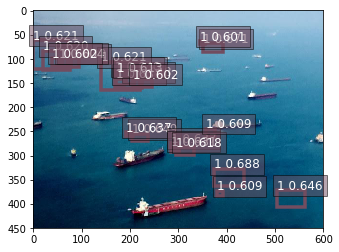

In [134]:
object_categories = ['ship']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.6

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

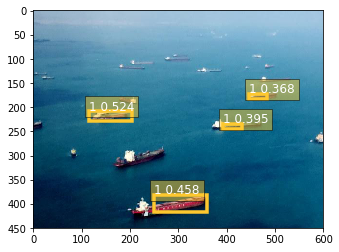

In [138]:
object_categories = ['ship']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.35

# Visualize the detections.
visualize_detection(file_name, detections2['prediction'], object_categories, threshold)